In [10]:
#!/usr/bin/env python
# import analyzer
import importlib
from importlib import reload
import os, sys, glob, warnings, glob
import numpy as np
import scipy as sp
import scipy.constants
import joblib
# from tqdm.notebook import tqdm
from tqdm import tqdm
import ROOT as root
from pylab import *

import iminuit
from iminuit import Minuit, cost

import matplotlib.pyplot as plt
from matplotlib import collections, colors, transforms
%matplotlib inline
%config InlineBackend.figure_format='retina'
# %matplotlib widget

In [15]:
class Hit:
    def __init__(self, x, y, z, t):
        self.x=x
        self.y=y
        self.z=z
        self.t=t
        self.t_uncertainty=1
    def get_uncertainty(self):
        # Get the layer-dependent uncertainty of each hit
        self.hit_layer=cut.in_layer(self.y)
        hit_uncertainty = np.array(detector.Layer().uncertainty(self.hit_layer))
        self.x_uncertainty=hit_uncertainty[0]*100 # m->cm
        self.z_uncertainty=hit_uncertainty[2]*100 # m->cm
        self.y_uncertainty=2/np.sqrt(12)

def gen_hits(Vx=2,Vy=29,Vz=3,x0=450,z0=450+11950):
    Y_LAYERS = np.arange(100)*100 #cm
    np.delete(Y_LAYERS,2)
    np.delete(Y_LAYERS,2)
    np.delete(Y_LAYERS,2)
    unc_low = 0.04/np.sqrt(12)*100 #cm
    unc_high = 1*sp.constants.c/1e7/np.sqrt(2)/1.5 #cm
    UNC_X = np.ones(100)
    UNC_Z = np.ones(100)
    for i in range(len(UNC_X)):
        if i%2==0:
            UNC_X[i]=unc_low
            UNC_Z[i]=unc_high
        else:
            UNC_X[i]=unc_high
            UNC_Z[i]=unc_low
            
    UNC_T = 1 #ns
    UNC_Y = 2/np.sqrt(12) #uncertainty in thickness, cm

    hits=[]
    hits_truth=[]
    hits_err=[]
    for i in range(len(Y_LAYERS)):
        t=(Y_LAYERS[i]-Y_LAYERS[0])/Vy
        hits_truth.append([x0+Vx*t,Y_LAYERS[i], z0+Vz*t, t])
        hits.append(Hit(x0+Vx*t+np.random.normal(0,UNC_X[i]),
                     Y_LAYERS[i],
                     z0+Vz*t+np.random.normal(0,UNC_Z[i]),
                     t+np.random.normal(0,UNC_T)))
        hits[-1].x_uncertainty=UNC_X[i]
        hits[-1].z_uncertainty=UNC_Z[i]
        hits[-1].y_uncertainty=UNC_Y
        hits_err.append([UNC_X[i],UNC_Y,UNC_Z[i],UNC_T])
        
    return np.array(hits),np.array(hits_err),np.array(hits_truth)

In [16]:
# Generated toy hits

N_events=500
Hit_collection={}
Truth_collection ={}
for i in range(N_events):
    Hit_collection[i],_,Truth_collection[i]=gen_hits()

## 1. Define LS fit

In [6]:
# -------------------------------------
# LS fit
# ------------------------------------
class chi2_track:
    def __init__(self, hits):
        self.hits=hits
        self.func_code = iminuit.util.make_func_code(['x0', 'y0', 'z0', 't0', 'vx', 'vy', 'vz'])
    def __call__(self, x0, y0, z0, t0, vx, vy, vz):
        error=0
        for hit in self.hits:
            model_t = (hit.y - y0)/vy
            model_x = x0 + model_t*vx
            model_z = z0 + model_t*vz
            error+= np.sum(np.power([(model_t- (hit.t-t0))/hit.t_uncertainty, 
                                     (model_x-hit.x)/hit.x_uncertainty, 
                                     (model_z-hit.z)/hit.z_uncertainty],2))
        return error        

def guess_track(hits):
    # Guess initial value
    x0_init = hits[0].x
    y0_init = hits[0].y
    z0_init = hits[0].z
    t0_init = hits[0].t
    dt=hits[1].t-hits[0].t
    vx_init = (hits[1].x-hits[0].x)/dt
    vy_init = (hits[1].y-hits[0].y)/dt
    vz_init = (hits[1].z-hits[0].z)/dt
    v_mod = np.sqrt(vx_init**2+vy_init**2+vz_init**2)
    if v_mod>sp.constants.c*1e-7:
        vx_init = vx_init*0.99*sp.constants.c*1e-7/v_mod
        vy_init = vy_init*0.99*sp.constants.c*1e-7/v_mod
        vz_init = vz_init*0.99*sp.constants.c*1e-7/v_mod
    return  (x0_init,y0_init, z0_init,t0_init,vx_init,vy_init,vz_init)
    
def fit_track(hits, guess):
    x0_init,y0_init, z0_init,t0_init,vx_init,vy_init,vz_init = guess
    det=detector.Detector()

    m = Minuit(chi2_track(hits),x0=x0_init, y0=y0_init, z0=z0_init, t0=t0_init, vx=vx_init, vy=vy_init, vz=vz_init)
    m.fixed["y0"]=True
    m.limits["x0"]=(det.BoxLimits[0][0],det.BoxLimits[0][1])
    m.limits["z0"]=(det.BoxLimits[2][0],det.BoxLimits[2][1])
    m.limits["t0"]=(0,1e5)
    m.limits["vx"]=(-sp.constants.c*1e-7, sp.constants.c*1e-7) # Other
    m.limits["vy"]=(-sp.constants.c*1e-7,0) if vy_init<0 else (0,sp.constants.c*1e-7) # Constrain the direction in Z(up) in real world
    m.limits["vz"]=(-sp.constants.c*1e-7, sp.constants.c*1e-7) # Beam direction; From MKS unit to cm/ns = 1e2/1e9=1e-7
    m.errors["x0"]=0.1
    m.errors["y0"]=0.1
    m.errors["z0"]=0.1
    m.errors["t0"]=0.3
    m.errors["vx"] = 0.01
    m.errors["vy"] = 0.1
    m.errors["vz"] = 0.01

    m.migrad()  # run optimiser
    m.hesse()   # run covariance estimator
    
    return m

## Define Kalman filter, 3 parameters, Q=3

In [56]:
# ----------------------------------------------------------------------
def Seed(hits):
#     c=sp.constants.c/1e7
    c=29.97
    seeds=[]
    for i in range(len(hits)):
        for j in range(i+1, len(hits)):
            dx = hits[i].x- hits[j].x
            dy = hits[i].y- hits[j].y
            dz = hits[i].z- hits[j].z
            dt = hits[i].t- hits[j].t
            ds = np.abs((dx**2+dy**2-dz**2)/c**2-dt**2)
#             print(i,j, ds)
#             print(hits[i].x, hits[i].z,hits[j].x, hits[j].z)
            if ds>5:
                continue
                
#             seeds.append([hits[i],hits[j]])
            seeds.append([i,j,ds])
    return np.array(seeds)

def init_state(hits):
    score = Seed(hits)
    ind=np.argmin(score[:,2])
#     ind=0
    i=int(score[ind][0])
    j=int(score[ind][1])
#     print(i,j)
    i=0
    j=1
    
    dt=hits[j].t-hits[i].t
    dx=hits[j].x-hits[i].x
    dy=hits[j].y-hits[i].y
    dz=hits[j].z-hits[i].z
    
#     print(dx,dy,dz,dt)
    
    # Initial State Vector: X0
    X0 = np.array([hits[0].x, hits[0].t, hits[0].z, dx/dt, dy/dt, dz/dt])
#     X0 = np.array([hits[1].x, hits[1].t, hits[1].z, dx/dt, dy/dt, dz/dt])
    
    # Initial Variance P0
    J =np.array([[ 1      , 0           , 0       , 0       , 0       , 0             , 0     , 0     ],
        [ 0       , 1           , 0       , 0       , 0       , 0             , 0     , 0     ],
        [ 0       , 0           , 1       , 0       , 0       , 0             , 0     , 0     ],
        [- 1 / dt, dx / (dt*dt), 0       , 0       , 1 / dt  , - dx / (dt*dt), 0     , 0     ],
        [0       , dy / (dt*dt), 0       , - 1 / dt, 0       , - dy / (dt*dt), 0     , 1 / dt],
        [0       , dz / (dt*dt), - 1 / dt, 0       , 0       , - dz / (dt*dt), 1 / dt, 0     ]])
#     # Initial Variance P0
#     J =np.array([[ 0      , 0           , 0       , 0       , 1       , 0             , 0     , 0     ],
#                 [ 0       , 0           , 0       , 0       , 0       , 1             , 0     , 0     ],
#                 [ 0       , 0           , 0       , 0       , 0       , 0             , 1     , 0     ],
#                 [- 1 / dt, dx / (dt*dt), 0       , 0       , 1 / dt  , - dx / (dt*dt), 0     , 0     ],
#                 [0       , dy / (dt*dt), 0       , - 1 / dt, 0       , - dy / (dt*dt), 0     , 1 / dt],
#                 [0       , dz / (dt*dt), - 1 / dt, 0       , 0       , - dz / (dt*dt), 1 / dt, 0     ]])
    err0=np.diag([hits[i].x_uncertainty,hits[i].t_uncertainty,hits[i].z_uncertainty,hits[i].y_uncertainty,
                 hits[j].x_uncertainty,hits[j].t_uncertainty,hits[j].z_uncertainty,hits[j].y_uncertainty])**2
    P0=J.dot(err0).dot(J.T)
    
    return X0, P0

def init_state_LS(hits,x0,x0_cov):
    # Initial State Vector: X0
    X0 = np.array([x0[0], x0[2], x0[2], x0[3], x0[4], x0[5]])
    P0=x0_cov
    
    return X0, P0

def add_measurement(hit, X_current, dy):
    vy_current = X_current[4]
    dt_next = dy/vy_current
    Y = np.array([hit.x,hit.t,hit.z])
    R = np.diag([hit.x_uncertainty,hit.t_uncertainty,hit.z_uncertainty])**2
    A = np.array([[1, 0, 0, dt_next, 0, 0],
                  [0, 1, 0, 0, dt_next/vy_current, 0],
                  [0, 0, 1, 0, 0, dt_next],
                  [0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 1]])
    return  Y,R,A


def fit_kf_1(hits, init_truth=None):
    # Initial state (X0), covariance (P0), measurement (X0)
    if init_truth is None:
        X0,P0 = init_state(hits)
    else:
        X0,P0 = init_state_LS(hits,*init_truth)
        
    M0=X0[:3]
    # Initial Measurement Matrix: M = HX + z, project from state vector to measurement
    H = np.array(\
        [[1,0,0,0,0,0],
         [0,1,0,0,0,0],
         [0,0,1,0,0,0]])
    # Initial propogation covariacne (Q)
    Q=0

    # Kalman Filter Object
    kf = Kalman_tom.KalmanFilter(X0,P0,M0,H=H)

    # Filter forward
    for i in range(1,7):
        hit = hits[i]
        dy = hits[i].y-hits[i-1].y

        X_previous = kf.X_filtered[-1]
        M_current,R,A = add_measurement(hit, X_previous, dy)
        kf.predict_foward(A,Q)
        kf.filter_forward(M_current,R)

    # Filter backward
    X_smoothed, p = kf.filter_backward()
    
    return kf

## Define Kalman filter, 3 parameters, initialize with infinity covariance and step from 0

In [20]:
# def add_measurement(hit, X_current, dy):
#     vy_current = X_current[4]
#     dt_next = dy/vy_current
#     Y = np.array([hit.x,hit.t,hit.z])
#     R = np.diag([hit.x_uncertainty,hit.t_uncertainty,hit.z_uncertainty])**2
#     A = np.array([[1, 0, 0, dt_next, 0, 0],
#                   [0, 1, 0, 0, dt_next/vy_current, 0],
#                   [0, 0, 1, 0, 0, dt_next],
#                   [0, 0, 0, 1, 0, 0],
#                   [0, 0, 0, 0, 1, 0],
#                   [0, 0, 0, 0, 0, 1]])
#     return  Y,R,A


# # def fit_kf_1(hits, init_truth=None):
# #     # Initial state (X0), covariance (P0), measurement (X0)
# #     if init_truth is None:
# #         X0,P0 = init_state(hits)
# #     else:
# #         X0,P0 = init_state_LS(hits,*init_truth)
# hits=Hit_collection[0]
# if 1:
# #     X0=np.ones(6)
#     X0=[hits[0].x,hits[0].t,hits[0].z,0,0,0]
#     P0=np.diag([1e10]*6)
        
#     M0=X0[:3]
#     # Initial Measurement Matrix: M = HX + z, project from state vector to measurement
#     H = np.array(\
#         [[1,0,0,0,0,0],
#          [0,1,0,0,0,0],
#          [0,0,1,0,0,0]])
#     # Initial propogation covariacne (Q)
#     Q=0

#     # Kalman Filter Object
#     kf = Kalman_tom.KalmanFilter(X0,P0,M0,H=H)

#     # Filter forward
#     for i in range(1,7):
#         hit = hits[i]
#         dy = hits[i].y-hits[i-1].y

#         X_previous = kf.X_filtered[-1]
#         M_current,R,A = add_measurement(hit, X_previous, dy)
#         kf.predict_foward(A,Q)
#         kf.filter_forward(M_current,R)

#     # Filter backward
# #     X_smoothed, p = kf.filter_backward()
    
# #     return kf

In [17]:
for i in hits:
    print(i.x)

450.134973765572
431.3584050685774
485.5713849555339
479.8757406035412
498.1475207193628
484.18179614445586
510.68334962420647


## Define Kalman filter, 6 parameters, Q=3

x = x0 + vx/vy* (y-y0)
t = t0 +  1/vy* (y-y0)
z = z0 + vz/vy* (y-y0)

There are 6 parameters in total: (x0,t0,z0, vx,vy,vz). In order to make the transformation from parameters to measurements (x_i,t_i,z_i) linear, define k1 = vx/vy, k2 = 1/vy, k3 = vz/vy

In [45]:
# init_state() can be the same as the 3-parameter Kalman filter. Initial states are the same.
def init_state_2(hits):
    dt=hits[1].t-hits[0].t
    dx=hits[1].x-hits[0].x
    dy=hits[1].y-hits[0].y
    dz=hits[1].z-hits[0].z
    
    # Initial State Vector: X0
    X0 = np.array([hits[0].x, hits[0].t, hits[0].z, dx/dy, 1/dy, dz/dy])
    
    # Initial Variance P0
    J =np.array([[ 1      , 0           , 0       , 0       , 0       , 0       , 0     , 0     ],
                [ 0       , 1           , 0       , 0       , 0       , 0       , 0     , 0     ],
                [ 0       , 0           , 1       , 0       , 0       , 0       , 0     , 0     ],
                [- 1 / dy , 0           , 0       , dx / dy**2, 1 / dy  , 0     , 0     ,-dx / dy**2],
                [0        , 0           , 0       ,  1 / dy**2, 0       , 0     , 0     , -1 / dy**2],
                [0        , 0           , -1/dy   , dz / dy**2, 0       , 0     , 1/dy  ,-dz / dy**2]])
    err0=np.diag([hits[0].x_uncertainty,hits[0].t_uncertainty,hits[0].z_uncertainty,hits[0].y_uncertainty,
                 hits[1].x_uncertainty,hits[1].t_uncertainty,hits[1].z_uncertainty,hits[1].y_uncertainty])**2
    P0=J.dot(err0).dot(J.T)
    
    return X0, P0


# Here the Prediction matrix A will be different. It is purely diagonal.
def add_measurement_2(hit, X_current, dy):
    vy_current = X_current[4]
    dt_next = dy/vy_current
    Y = np.array([hit.x,hit.t,hit.z])
    R = np.diag([hit.x_uncertainty,hit.t_uncertainty,hit.z_uncertainty])**2
    A = np.identity(6)
    return  Y,R,A


def fit_kf_2(hits):
    # Initial state (X0), covariance (P0), measurement (X0)
    X0,P0 = init_state(hits)
    M0=X0[:3]
    # Initial propogation covariacne (Q)
    Q=0

    # Kalman Filter Object
    kf = Kalman_tom.KalmanFilter(X0,P0,M0)

    # Filter forward
    for i in range(1,7):
        hit = hits[i]
        dy = hits[i].y-hits[0].y
        
        # Initial Measurement Matrix: M = HX + z, project from state vector to measurement
        H = np.array(\
            [[1,0,0,dy,0,0],
             [0,1,0,0,dy,0],
             [0,0,1,0,0,dy]])        

        X_previous = kf.X_filtered[-1]
        M_current,R,A = add_measurement(hit, X_previous, dy)
        kf.predict_foward(A,Q)
        kf.filter_forward(M_current,R,H=H)

    # Filter backward
    X_smoothed, p = kf.filter_backward()
    
    return kf

In [22]:
hits_truth=Truth_collection[0]

In [23]:
reload(Kalman_tom)

<module 'Kalman_tom' from '/project/6035200/tomren/jupyter/tracker_analysis/Kalman_tom.py'>

[4.51475454e+02 1.21394665e+00 1.24043790e+04 1.41862274e+00
 1.51085814e+01 2.11472972e+00]


/tmp/ipykernel_19633/2618061123.py:56: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


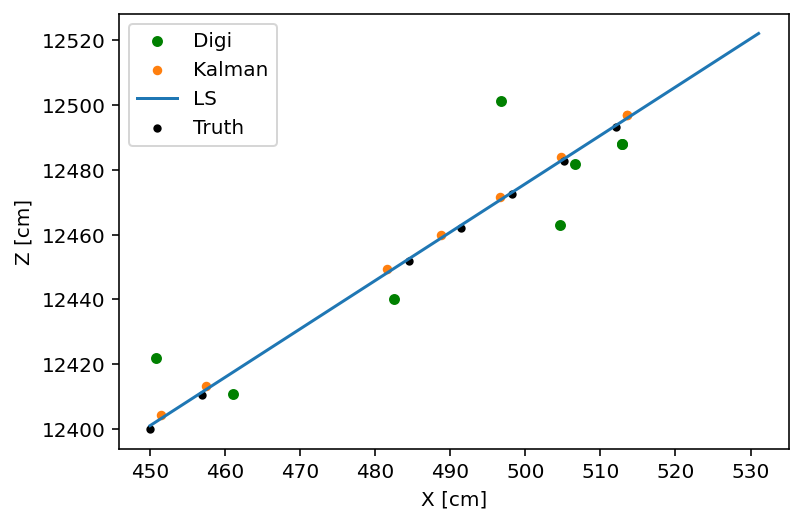

In [58]:
# # Turth
# dt=hits_truth[1][3]-hits_truth[0][3]
# dx=hits_truth[1][0]-hits_truth[0][0]
# dy=hits_truth[1][1]-hits_truth[0][1]
# dz=hits_truth[1][2]-hits_truth[0][2]
# X0_truth = np.array([hits_truth[0][0], hits_truth[0][3], hits_truth[0][2], dx/dt, dy/dt, dz/dt])
# # Xlast_truth = np.array([hits_truth[-1][0], hits_truth[-1][3], hits_truth[-1][2], dx/dt, dy/dt, dz/dt])
# # print(Xlast_truth)
# # print(kf.X_filtered[-1])


# Get one event
# ievent=5
# ievent+=1
hits=Hit_collection[ievent]
truth=Truth_collection[ievent]

# Run fits
# 1. LS
guess=guess_track(hits)
fit1=fit_track(hits,guess)
#print(fit1)
# 2. Kalman, 3 par, Q=0
values=list(fit1.values)
del values[1]
a=np.array(fit1.covariance.tolist())
a=np.delete(a,1,0)
a=np.delete(a,1,1)
errors=a
init_truth = [values,errors]
# kf1=fit_kf_1(hits,init_truth=init_truth)  
kf1=fit_kf_1(hits)  
print(kf1.X_smoothed[0])


# Plot digitized and Kalman
for i in range(7):
    scatter(hits[i].x, hits[i].z,color="g",s=20)    
#     scatter(kf2.X_filtered[i][0], kf2.X_filtered[i][2],color="C0",s=14)
    scatter(kf1.X_smoothed[i][0], kf1.X_smoothed[i][2],color="C1",s=14)
#     scatter(kf2.X_smoothed[i][0], kf2.X_smoothed[i][2],color="C3",s=14)    
scatter(hits[i].x, hits[i].z,color="g",s=20,label="Digi")    
# scatter(kf1.X_filtered[i][0], kf1.X_filtered[i][2],color="C0",s=14,label="Kalman, predict ")    
scatter(kf1.X_smoothed[i][0], kf1.X_smoothed[i][2],color="C1",s=14,label="Kalman")    
# scatter(kf2.X_smoothed[i][0], kf2.X_smoothed[i][2],color="C3",s=14,label="Kalman, v_init=LS")    


# Plot LS
fit1_res = list(fit1.values)
tlist = np.linspace(0,1000/25,10)
x_plot = fit1_res[0]+fit1_res[4]*tlist
z_plot = fit1_res[2]+fit1_res[6]*tlist
plot(x_plot,z_plot,label="LS")

# Plot Truth
hits_truth=np.array(hits_truth)
scatter(hits_truth[:,0],hits_truth[:,2],s=10,color="k",label="Truth")
# x_plot = truth[0]+truth[4]*tlist
# z_plot = truth[2]+truth[6]*tlist
# plot(x_plot,z_plot,label="Truth",color="r",linestyle=":")
# scatter(truth[0],truth[2],marker="*",color="r")


xlabel("X [cm]")
ylabel("Z [cm]")
legend()

In [59]:
values

[450.02096990489343,
 12400.969034317814,
 0.7860859316449319,
 2.0261293637920255,
 29.72549518051154,
 3.028328063284403]

[4.50042423e+02 1.06210076e-01 1.23991812e+04 1.70517510e+00
 2.11957050e+01 2.58438813e+00]


/tmp/ipykernel_19633/2618061123.py:56: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


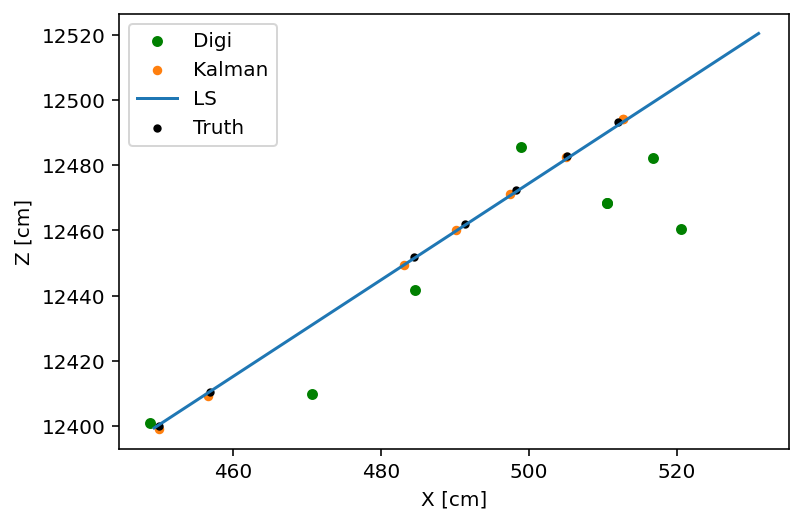

In [24]:
# # Turth
# dt=hits_truth[1][3]-hits_truth[0][3]
# dx=hits_truth[1][0]-hits_truth[0][0]
# dy=hits_truth[1][1]-hits_truth[0][1]
# dz=hits_truth[1][2]-hits_truth[0][2]
# X0_truth = np.array([hits_truth[0][0], hits_truth[0][3], hits_truth[0][2], dx/dt, dy/dt, dz/dt])
# # Xlast_truth = np.array([hits_truth[-1][0], hits_truth[-1][3], hits_truth[-1][2], dx/dt, dy/dt, dz/dt])
# # print(Xlast_truth)
# # print(kf.X_filtered[-1])


# Get one event
ievent=5
# ievent+=1
hits=Hit_collection[ievent]
truth=Truth_collection[ievent]

# Run fits
# 1. LS
guess=guess_track(hits)
fit1=fit_track(hits,guess)
#print(fit1)
# 2. Kalman, 3 par, Q=0
values=list(fit1.values)
errors=list(fit1.errors)
del values[1]
del errors[1]
init_truth = [values,errors]
# kf2=fit_kf_1(hits,init_truth=init_truth)  
kf1=fit_kf_1(hits)  
print(kf1.X_smoothed[0])


# Plot digitized and Kalman
for i in range(7):
    scatter(hits[i].x, hits[i].z,color="g",s=20)    
#     scatter(kf2.X_filtered[i][0], kf2.X_filtered[i][2],color="C0",s=14)
    scatter(kf1.X_smoothed[i][0], kf1.X_smoothed[i][2],color="C1",s=14)
#     scatter(kf2.X_smoothed[i][0], kf2.X_smoothed[i][2],color="C3",s=14)    
scatter(hits[i].x, hits[i].z,color="g",s=20,label="Digi")    
# scatter(kf1.X_filtered[i][0], kf1.X_filtered[i][2],color="C0",s=14,label="Kalman, predict ")    
scatter(kf1.X_smoothed[i][0], kf1.X_smoothed[i][2],color="C1",s=14,label="Kalman")    
# scatter(kf2.X_smoothed[i][0], kf2.X_smoothed[i][2],color="C3",s=14,label="Kalman, v_init=LS")    


# Plot LS
fit1_res = list(fit1.values)
tlist = np.linspace(0,1000/25,10)
x_plot = fit1_res[0]+fit1_res[4]*tlist
z_plot = fit1_res[2]+fit1_res[6]*tlist
plot(x_plot,z_plot,label="LS")

# Plot Truth
hits_truth=np.array(hits_truth)
scatter(hits_truth[:,0],hits_truth[:,2],s=10,color="k",label="Truth")
# x_plot = truth[0]+truth[4]*tlist
# z_plot = truth[2]+truth[6]*tlist
# plot(x_plot,z_plot,label="Truth",color="r",linestyle=":")
# scatter(truth[0],truth[2],marker="*",color="r")


xlabel("X [cm]")
ylabel("Z [cm]")
legend()

In [177]:
    X0,P0 = init_state(hits)
    M0=X0[:3]
    # Initial Measurement Matrix: M = HX + z, project from state vector to measurement
    H = np.array(\
        [[1,0,0,0,0,0],
         [0,1,0,0,0,0],
         [0,0,1,0,0,0]])
    # Initial propogation covariacne (Q)
    Q=0

    # Kalman Filter Object
    kf = Kalman_tom.KalmanFilter(X0,P0,M0,H=H)

    # Filter forward
    for i in range(1,7):
        hit = hits[i]
        dy = hits[i].y-hits[i-1].y

        X_previous = kf.X_filtered[-1]
        M_current,R,A = add_measurement(hit, X_previous, dy)
        kf.predict_foward(A,Q)
        kf.filter_forward(M_current,R)

    # Filter backward
    X_smoothed, p = kf.filter_backward()

2 3
-21.31522934916103 397.0 100.55947646688583 12.375279051455733


In [178]:
X0/30

array([ 1.43463721e+01,  2.66039423e-01,  4.16275000e+02, -5.74134645e-02,
        1.06933616e+00,  2.70861169e-01])

In [179]:
for i in range(7):
    print( kf1.X_filtered[i]/30)

[ 1.43463721e+01  2.66039423e-01  4.16275000e+02 -5.74134645e-02
  1.06933616e+00  2.70861169e-01]
[ 1.41890033e+01  3.68464830e-01  4.16698618e+02 -4.96279323e-02
  1.04444741e+00  3.10831957e-01]
[ 1.35699161e+01  6.79818258e-01  4.19314665e+02 -4.89675454e-02
  8.00200083e-01  1.67097417e-01]
[ 1.27064581e+01  8.46991022e-01  4.20022577e+02 -8.39585114e-02
  8.17890979e-01  1.60727003e-01]
[ 1.23411769e+01  9.95022635e-01  4.20487165e+02 -8.45615314e-02
  8.32055576e-01  1.38818757e-01]
[ 1.20597621e+01  1.14353502e+00  4.21045588e+02 -8.17980522e-02
  8.39981547e-01  1.36863223e-01]
[ 1.17203943e+01  1.27068887e+00  4.21777891e+02 -8.19873518e-02
  8.26842135e-01  1.48196292e-01]


In [20]:
results={}
# results["hits"]=[]
results["hits_truth"]=[]
results["recon_0"]=[]
results["recon_0_err"]=[]
results["recon_1"]=[]
results["recon_1_err"]=[]

for i in tqdm(range(len(Hit_collection))):
# for i in range(10):
    # Get one event and fit
    hits=Hit_collection[i]
    truth=Truth_collection[i]
    
    
    # 0: LSfit
    guess=guess_track(hits)
    fit1=fit_track(hits,guess)
    # 1: Kalman 3 par, Q=0
    kf1=fit_kf_1(hits)  
    
    
    #print(fit1)
    lsfit_values = [fit1.values[0],fit1.values[3],fit1.values[2],fit1.values[4],fit1.values[5],fit1.values[6]]
    results["recon_0"].append(lsfit_values)
    results["recon_1"].append(kf1.X_smoothed[0])
    results["hits_truth"].append([truth[0],truth[3],truth[2],truth[4],truth[5],truth[6]])

    
    
for key in results:
    results[key] = np.array(results[key])

  0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_18402/2618061123.py:56: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser
  1%|          | 3/500 [00:00<00:23, 20.83it/s]

4 6
-20.33869093246733 100 -10.558377309238494 4.1350163140228915
3 6
23.5680550614656 100 11.25520806577515 3.8582140321353267
0 1
-8.488954697324289 100 18.224242278569363 3.1240645664787725
0 3
20.148009189622712 100 8.057816668548185 3.6622517083589843
0 1
19.28845580306978 100 3.864998382206977 3.3769981726482525


  2%|▏         | 9/500 [00:00<00:24, 20.17it/s]

5 6
6.318270270503547 100 13.842197355203098 2.2172432243548
1 2
-11.229157773513066 100 21.939756065075926 2.719958292466458
4 5
13.135832245412587 100 -4.665137767795386 3.05381819098349
0 1
5.12514221676139 100 8.659271203554454 3.2857340127968504


  2%|▏         | 12/500 [00:00<00:25, 19.24it/s]

0 1
28.71047058762622 100 40.07635155964999 3.3103559185780758
5 6
-15.663347286272597 100 6.919667361586107 4.296502601552432
5 6
43.283729067013326 100 20.779396968213405 1.9699655424211362
1 3
-0.8757798625551914 100 30.717308543957188 2.483687647557552
0 1
1.5868552326710414 100 4.469985164354512 3.635401757911847


  4%|▎         | 18/500 [00:00<00:24, 19.34it/s]

4 5
-0.7263632729827236 100 38.88448547515509 3.4927332428474207
5 6
29.112594015164518 100 40.182833129900246 4.364369220644811
5 6
10.405279472897575 100 2.6878798144371103 5.293774910794044
3 5
-10.580647982160428 100 16.041935666040445 4.295108237868499


  4%|▍         | 21/500 [00:01<00:25, 18.65it/s]

5 6
4.538715973517242 100 0.5818808403655567 2.279810236187655
5 6
-18.619590975729636 100 1.3132568421733595 2.8216033900855217
5 6
1.9116771294657156 100 5.406245489641151 4.033893854066677
4 6
-6.858460159060712 100 -17.751145731675933 1.2563781629206625
2 3


  5%|▌         | 27/500 [00:01<00:23, 20.33it/s]

6.582277386605369 100 13.105057228820442 1.729250455622715
2 3
27.98315570931493 100 14.573360016374863 0.7008263708873327
4 6
22.316502935228698 100 24.979610167458304 2.037362867813653
3 4
-10.109815664851169 100 16.27483190390194 3.0004913650642133
2 3
-17.42864101122126 100 32.40059680446393 5.131645663757998


  6%|▌         | 30/500 [00:01<00:22, 20.54it/s]

1 4
12.820075338979791 100 15.264259255560319 5.068275864069792
0 3
33.629008610219216 100 -7.001653373630688 3.7604573705276083
5 6
3.421011466460868 100 5.870882613324284 2.920970995206784
4 6
-8.684073095182725 100 17.807473010490867 3.7641632414293014
3 4
8.770168251923906 100 8.236988933584144 3.9540725052659456


  7%|▋         | 36/500 [00:01<00:22, 20.64it/s]

4 5
49.94423374801693 100 41.92853026006014 3.0144603901072133
2 4
20.909247713567083 100 6.766411157463153 5.099235934451886
2 3
16.942120601657166 100 12.91798783583181 6.3490690008624115
5 6
30.477313772150637 100 -5.288825128855024 5.116670410221586
4 6
-6.082336477790761 100 8.94329685385128 1.847204667072719


  8%|▊         | 42/500 [00:02<00:21, 21.49it/s]

5 6
18.683542830297085 100 14.2230062814142 0.9336809853965186
4 6
-20.80465647926775 100 7.611411715835857 2.6966636405319906
1 4
12.4400124973414 100 38.76694017642512 4.895163030844143
0 1
-12.920734120713178 100 0.7452665308937867 3.3161968083070104
4 6
-7.445243690036705 100 3.9793280504018185 2.6714810191955003


  9%|▉         | 45/500 [00:02<00:21, 21.54it/s]

0 1
-13.345588858432905 100 20.68110885988972 3.8745252833892825
5 6
12.432295933969158 100 11.623261401869968 3.9875120663358783
3 4
-12.446328482891829 100 8.420740522311462 2.59017506231075
2 3
6.81470115196322 100 21.254781927742442 4.530506757609972
2 4
-3.0491550827005653 100 -4.290246507345728 3.7942028422505163


 10%|█         | 51/500 [00:02<00:21, 21.01it/s]

2 5
8.060489023980097 100 21.464261628902022 2.9390381049191183
5 6
-10.757126394225793 100 41.82950527196772 2.335962235186373
5 6
1.7537283930246303 100 15.879776106119607 4.368584592479214
2 4
-1.0499605766249829 100 8.347505642108445 3.7898028196522304
2 3
18.919332852626383 100 13.086319682808607 5.573945140749988


 11%|█▏        | 57/500 [00:02<00:19, 22.24it/s]

5 6
37.784248210642374 100 -2.2380370963710448 3.0504526840293265
3 4
8.458822763224362 100 42.85730314145076 6.2346250384927195
0 1
7.450294255346705 100 10.884272072686144 3.1714170897720715
2 5
4.6381679077283025 100 -5.594249481206134 4.424106083240396
2 5
7.763568366218294 100 0.9251547478870634 5.61980679314491


 12%|█▏        | 60/500 [00:02<00:19, 22.24it/s]

2 6
8.138020696383876 100 16.13247327017234 4.27393414407217
1 3
25.82488247697262 100 -7.136618352446021 2.9468974476619616
4 5
-4.721977785883439 100 -10.094840744148314 4.148574324566353
3 6
-0.3717129880279799 100 5.994988980832204 4.142651559174973
0 1
0.6014490304479523 100 33.48108845612114 2.6362317302144707


 13%|█▎        | 63/500 [00:03<00:21, 20.64it/s]


5 6
4.991099468640471 100 7.236149001575541 2.010423561981226


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
Truth_collection[0]


KeyboardInterrupt



In [17]:
results_fit=results

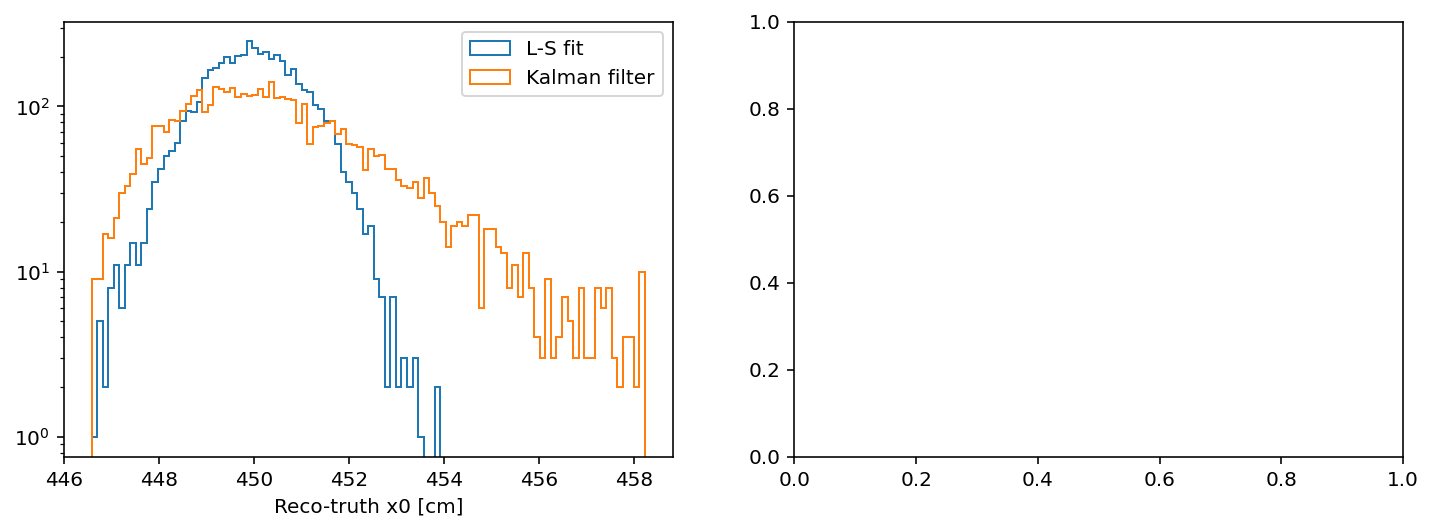

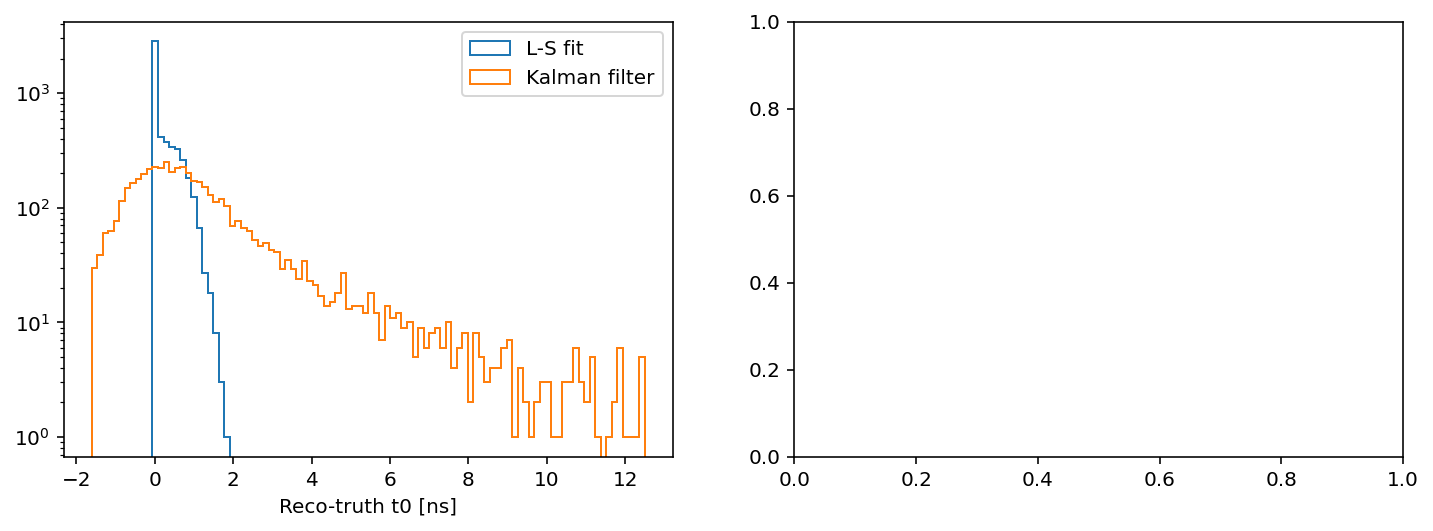

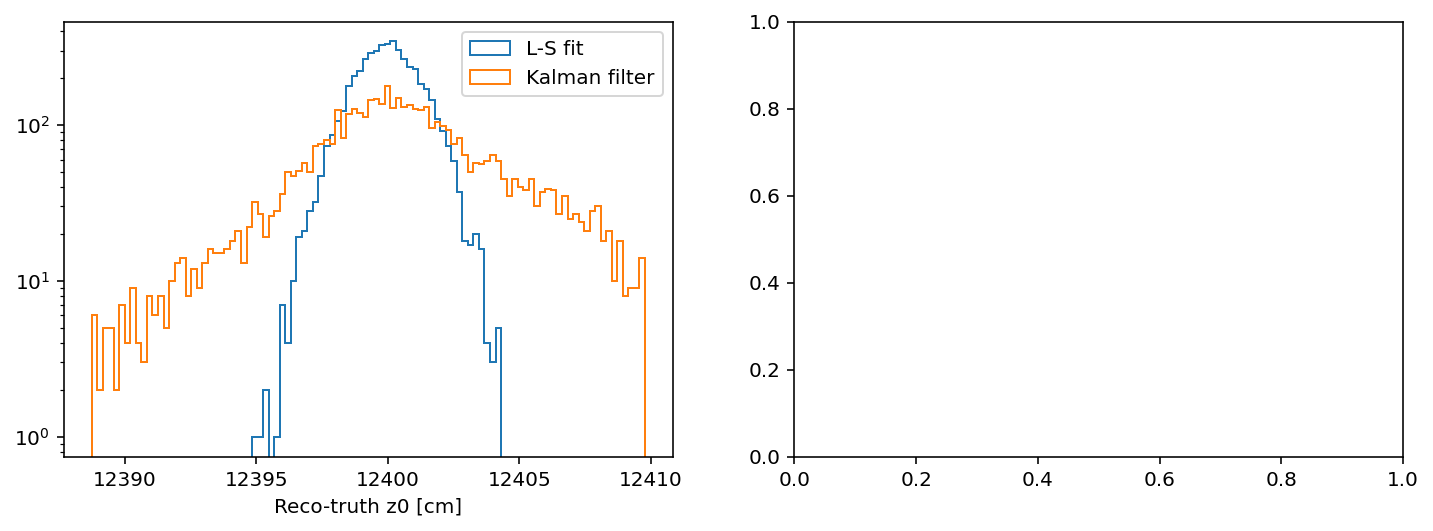

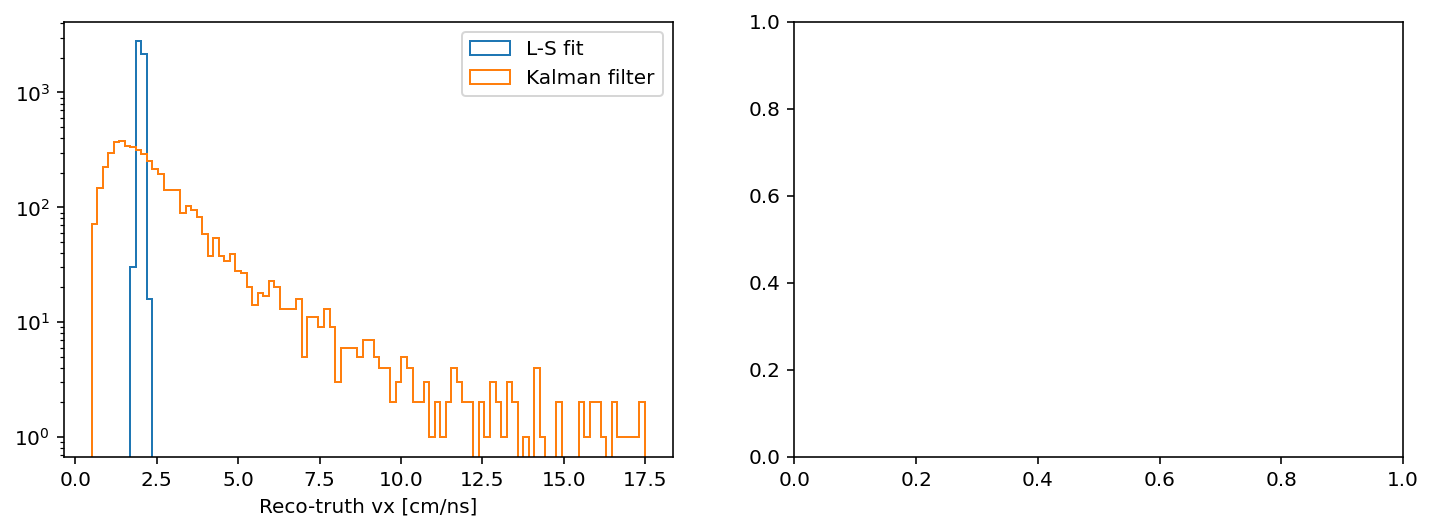

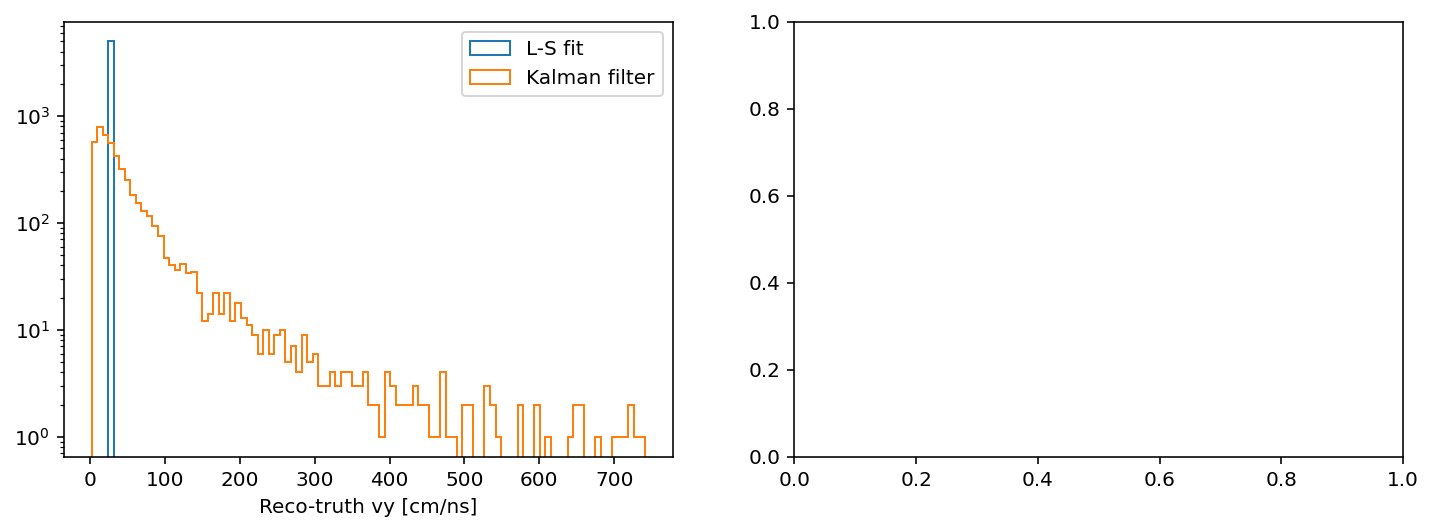

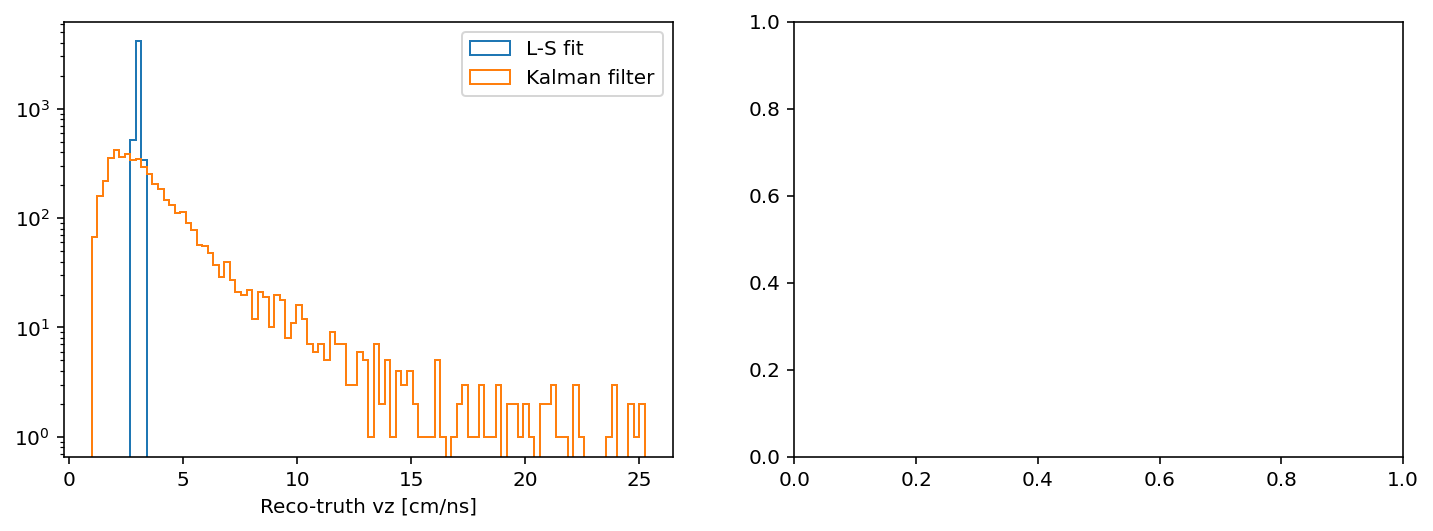

In [22]:
par_names=['x0', 't0','z0',  'vx', 'vy', 'vz'] # Use real world direction
par_unit= ["[cm]",'[ns]',"[cm]","[cm/ns]","[cm/ns]","[cm/ns]"]
# ranges=[(-20,20),(-20,20),(-20,20),(-20,20),(-30,30),(-30,30),(-30,30)]

for ipar in range(6):
    #_range=ranges[ipar]
    residual_ls=results_fit["recon_0"][:,ipar]#-results_fit["hits_truth"][:,ipar]
    residual_km=results_fit["recon_1"][:,ipar]#-results_fit["hits_truth"][:,ipar]
    _range=(np.percentile(residual_km,1),np.percentile(residual_km,99))
    
    def pull(x_measure, x_truth, x_unc):
        return (x_measure-x_truth)/x_unc
#     pull_ls=pull(residual_ls,0,results_fit["par_fit_error"][:,ipar])
#     pull_km=pull(residual_km,0,results_fit["par_fit_error"][:,ipar])
    
    fig,axs=plt.subplots(1,2,figsize=(12,4))
    plt.sca(axs[0])
    plt.hist(residual_ls,histtype="step",bins=100,range=_range,label="L-S fit");#bins=np.linspace(360,500,100));
    plt.hist(residual_km,histtype="step",bins=100,range=_range,label="Kalman filter");#bins=np.linspace(360,500,100));
    plt.legend()
    plt.xlabel(f"Reco-truth {par_names[ipar]} {par_unit[ipar]}")
    plt.yscale("log")
#     plt.sca(axs[1])
#     plt.hist(pull_ls,histtype="step",bins=100,range=(-5,5),label="L-S fit");#bins=np.linspace(360,500,100));
#     plt.hist(pull_km,histtype="step",bins=100,range=(-5,5),label="Kalman filter");#bins=np.linspace(360,500,100));
#     plt.legend()
#     plt.xlabel(f"Reco-truth/Reco_unc {par_names[ipar]} [sigma]")
#     plt.yscale("log")    
    
    
    plt.show()

In [ ]:
hist(results["recon_0"][:,0]-results["hits_truth"][:,0],bins=100,histtype="step");
hist(results["recon_1"][:,0]-results["hits_truth"][:,0],bins=100,histtype="step");
yscale("log")

In [174]:
filename='/project/def-mdiamond/tomren/mathusla/data/fit_study/muon_1000_GeV_manual/20230129/192716/stat0.root'
tfile = root.TFile.Open(filename)
tree_name = ["integral_tree","box_run"][0]
Tree = tfile.Get(tree_name)


Tree.GetEntry(0);

# print(Tree.Digi_numHits[:10]),len(Tree.Digi_energy)

# for i in range(int(Tree.NumHits)):
#     print(Tree.Hit_x[i], Tree.Hit_y[i], Tree.Hit_z[i], Tree.Hit_energy[i], Tree.Hit_time[i])

for i in range(len(Tree.Digi_numHits)):
    print(Tree.Digi_x[i], Tree.Digi_time[i], Tree.Digi_y[i],Tree.Digi_energy[i], Tree.Digi_particle_energy[i], Tree.Digi_pdg_id[i], Tree.Digi_seed)

430.39116376986135 7.981182692852532 8551.5 4.918235023094326 999991.1385367073 13 1
425.75 11.215559478644328 8654.5 3.202745982916346 999983.994739069 13 1
404.43477065083897 23.59083853010006 9051.5 7.575749089679223 999970.8070138452 13 1
380.75 26.975060088343028 9154.5 3.3948903588160597 999960.719051912 13 1
339.80371415058465 29.63413706773283 9257.5 4.212334862383561 999952.4804774097 13 1
362.75 35.24402654869914 9360.5 3.6519575939633504 999943.8299937556 13 1
332.48587738552453 38.37904489108086 9463.5 3.5139167328937297 999935.115808346 13 1
